In [243]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [244]:
x_range = [-10, 10]
x_diff = x_range[1] - x_range[0]
def plot_func(func):
    x = np.arange(x_range[0], x_range[1], 0.01)
    y = func(x)
    plt.plot(x, y)

In [245]:
def plot_points(x, y):
    plt.xlim(x_range[0], x_range[1])
    plt.scatter(x, y)

In [246]:
def gpr_plot(func, x_train, y_train, x_test, mu, var):
    x = np.arange(x_range[0], x_range[1], 0.01)
    y = func(x)
    plt.plot(x, y)
    plt.scatter(x_train, y_train, color='orange')
    plt.scatter(x_test, mu+2*np.sqrt(var), color='green', s=25)
    plt.scatter(x_test, mu-2*np.sqrt(var), color='green', s=25)
    plt.scatter(x_test, mu, color='black', marker='x')

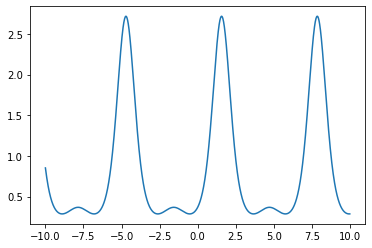

In [247]:
#target_func = lambda x: x*x
#target_func = lambda x: 2*x + np.sin(x) + np.cos(x)
target_func = lambda x: np.exp(np.sin(x) - np.cos(x)**2)
plot_func(target_func)

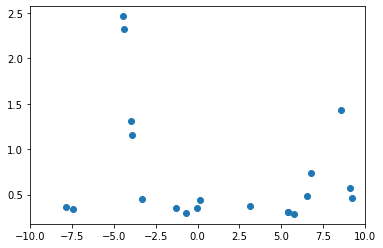

In [248]:
def reload_sample(n_sample=10, fig_on=False):
    get_sample = lambda num: (x_range[1] - x_range[0]) * np.random.rand(num, 1) + x_range[0]
    x_train = get_sample(n_sample)
    y_train = target_func(x_train)
    if fig_on:
        plot_points(x_train, y_train)
    return (x_train, y_train)
x_train, y_train = reload_sample(20, True)

In [249]:
def gauss_kernel(x1, x2, theta1, theta2):
    return theta1 * math.exp(-(x1 - x2)*(x1 - x2) / theta2)

In [250]:
def kernel_matrix (xx, kernel):
    N = len(xx)
    return np.array (
        [kernel (xi, xj) for xi in xx for xj in xx]
    ).reshape(N,N)

def gpr(x_test, x_train, y_train, kernel):
    n_train = len(x_train)
    n_test = len(x_test)
    k = np.zeros((n_train, n_test))
    s = np.zeros((n_test, n_test))
    #K = np.zeros((n_train, n_train))
    #for i in range(n_train):
    #    for j in range(n_train):
    #        K[i][j] = kernel(x_train[i], x_train[j])
    K = kernel_matrix(x_train, kernel)
    K_inv = np.linalg.inv(K)
    for i in range(n_train):
        for j in range(n_test):
            k[i][j] = kernel(x_train[i], x_test[j])
    for i in range(n_test):
        for j in range(n_test):
            s[i][j] = kernel(x_test[i], x_test[j])
    mu = k.T @ K_inv @ y_train
    _var = s - k.T @ K_inv @ k
    var = np.zeros(n_test)
    for i in range(n_test):
        var[i] = _var[i][i]
    return mu.reshape(-1), var

def gpr_flat(x_test, x_train, y_train, kernel):
    n_train = len(x_train)
    n_test = len(x_test)
    K = np.zeros((n_train, n_train))
    for i in range(n_train):
        for j in range(n_train):
            K[i][j] = kernel(x_train[i], x_train[j])
    K_inv = np.linalg.inv(K)
    mu = np.zeros((n_test))
    var = np.zeros((n_test))
    for i in range(n_test):
        k = np.zeros((n_train))
        for j in range(n_train):
            k[j] = kernel(x_test[i], x_train[j])
        s = kernel(x_test[i], x_test[i])
        mu[i] = k.T @ K_inv @ y_train
        var[i] = s - k.T @ K_inv @ k
    return mu, var



In [251]:
def gpr_plot_all(func, x_train, y_train, x_test, kernel):
    mu, var = gpr(x_test, x_train, y_train, kernel)
    x = np.arange(x_range[0], x_range[1], 0.01)
    y = func(x)
    plt.plot(x, y, color='red')
    plt.plot(x_test, mu, 'b-')
    plt.fill_between(x_test, mu-2*np.sqrt(var), mu+2*np.sqrt(var), color='#ccccff')
    plt.scatter(x_train, y_train, color='red', marker='x', s=100)

In [252]:
## train hyperparameters
## log p(y|x, t) = -log|K_t| - y^T @ K^-1 @ y  --> max_t

def evidence(x, y, theta):
    n_train = len(y)
    #kernel = lambda x1, x2, theta: gauss_kernel(x1, x2, theta[0], theta[1])
    #K = np.zeros((n_train, n_train))
    #for i in range(n_train):
    #    for j in range(n_train):
    #        K[i][j] = kernel(x[i], x[j], theta)
    kernel = lambda x1, x2: gauss_kernel(x1, x2, theta[0], theta[1])
    K = kernel_matrix(x, kernel)
    K_inv = np.linalg.inv(K)
    det = np.linalg.det(K)
    if np.isnan(det) or np.isinf(det): 
        return -1e18
    #print(theta)
    #print(det)
    #print(K)
    ev = -math.log(det) - y.T @ K_inv @ y
    return ev

## p = e^ev_func(init_theta)
def mcmc_opt(init_theta, ev_func, step, iter):
    theta = init_theta
    cur_p = math.exp(ev_func(theta))
    #print(ev_func(init_theta))
    for k in range(iter):
        r = np.random.rand(2) * 2*step - step
        next_theta = theta + r
        if any(next_theta <= 0):
            continue
        #print(next_theta)
        ev = ev_func(next_theta)
        #nex_p = np.exp(ev)
        nex_p = math.exp(ev)
        prob = np.random.rand()
        #print(f'prob={prob}, rhs={nex_p/cur_p}')
        if prob < (nex_p/cur_p):
            theta = next_theta
            cur_p = nex_p
        print(ev_func(theta))
    return theta

#evidence(x_train, y_train, [150.0, 0.4])
ev_func = lambda theta: evidence(x_train, y_train, theta)
init_theta = [15.0, 0.4]
step = 1.5
iter = 200
theta = mcmc_opt(init_theta, ev_func, step, iter)
print(theta)

[[-4.4660203]]
[[-4.4660203]]
[[-4.74345783]]
[[-4.74345783]]
[[-4.74345783]]
[[-4.74345783]]
[[9.43555418]]
[[9.43555418]]
[[9.43555418]]
[[9.43555418]]
[[9.43555418]]
[[9.43555418]]
[[9.43555418]]
[[9.43555418]]
[[9.43555418]]
[[9.43555418]]
[[9.43555418]]
[[9.43555418]]
[[9.43555418]]
[[9.43555418]]
[[9.43555418]]
[[9.43555418]]
[[9.43555418]]
[[9.43555418]]
[[9.43555418]]
[[9.43555418]]
[[9.43555418]]
[[9.43555418]]
[[9.43555418]]
[[9.71942842]]
[[9.71942842]]
[[9.71942842]]
[[9.71942842]]
[[9.71942842]]
[[9.71942842]]
[[9.71942842]]
[[9.71942842]]
[[9.71942842]]
[[9.71942842]]
[[9.66428545]]
[[9.66428545]]
[[9.66428545]]
[[9.66428545]]
[[9.66428545]]
[[9.66428545]]
[[9.01719531]]
[[9.01719531]]
[[6.79406025]]
[[6.79406025]]
[[9.25055412]]
[[13.12108724]]
[[13.45060262]]
[[13.45060262]]
[[13.45060262]]
[[13.45060262]]
[[11.03531025]]
[[11.03531025]]
[[13.78861745]]
[[13.78861745]]
[[13.78861745]]
[[13.78861745]]
[[13.78861745]]
[[13.78861745]]
[[13.78861745]]
[[13.78861745]]
[[13.7

In [253]:
#kernel = lambda x1, x2: gauss_kernel(x1, x2, theta[0], theta[1])
#x_test, _ = reload_sample(15)
#mu, var = gpr_flat(x_test, x_train, y_train, kernel)
#print(f'mu = {mu}, var = {var}')
#gpr_plot(target_func, x_train, y_train, x_test, mu, var)

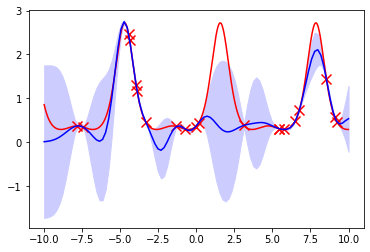

In [254]:
x_test_all = np.linspace(x_range[0], x_range[1], 100)
kernel = lambda x1, x2: gauss_kernel(x1, x2, theta[0], theta[1])
gpr_plot_all(target_func, x_train, y_train, x_test_all, kernel)